# Import libs

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torch.nn import ModuleList
from torch import nn
import torch.optim as optim
from torch_lr_finder import LRFinder

# custom libs
from libs.PretrainedModels import AlexNet_cc, SqueezeNet_cc, InceptionV3_cc, ResNet18_cc
from libs.utils import get_model_name, import_dataset, reverse_norm, init_model
from libs.Dataset import dst

In [2]:
random.seed(1996)
np.random.seed(1996)

In [4]:
batch_size=32
num_workers=2
drop_last=True

dst.create_data_loader(batch_size=batch_size, num_workers=num_workers, drop_last=drop_last)

## Visualizing dataset

#### Training

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


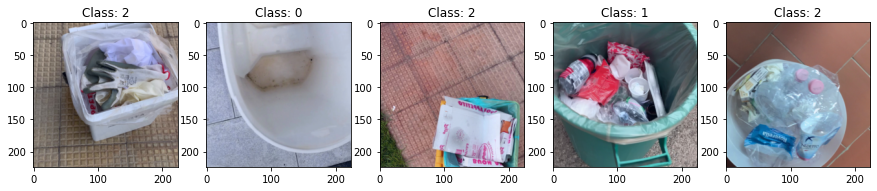

In [6]:
train_features, train_labels = next(iter(dst.training_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % train_labels[0].numpy())
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(reverse_norm(img.numpy().transpose(1, 2, 0)))
    train_features, train_labels = next(iter(dst.training_loader))
plt.show()

#### Validation

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


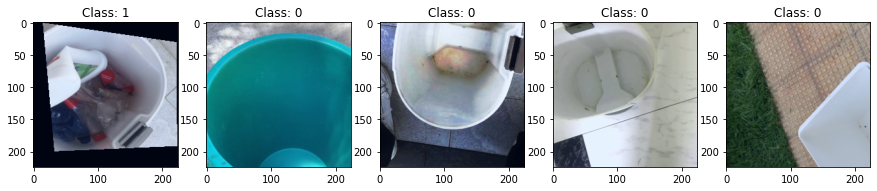

In [7]:
val_features, val_labels = next(iter(dst.validation_loader))
print(f"Feature batch shape: {val_features.size()}")
print(f"Labels batch shape: {val_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % val_labels[0].numpy())
    img = val_features[0].squeeze()
    label = val_labels[0]
    plt.imshow(reverse_norm(img.numpy().transpose(1, 2, 0)))
    val_features, val_labels = next(iter(dst.validation_loader))
plt.show()

#### Test

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


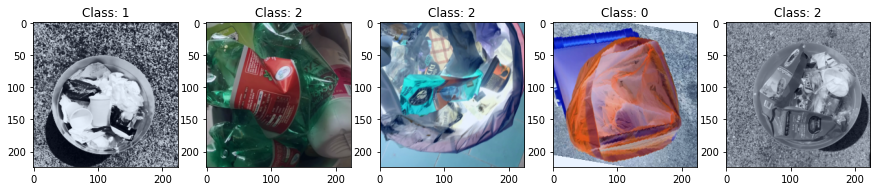

In [8]:
test_features, test_labels = next(iter(dst.test_loader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % test_labels[0].numpy())
    img = test_features[0].squeeze()
    label = test_labels[0]
    plt.imshow(reverse_norm(img.numpy().transpose(1, 2, 0)))
    test_features, test_labels = next(iter(dst.test_loader))
plt.show()

## Using LR finder libs

In [5]:
criterion = nn.CrossEntropyLoss()

optim_lr = 0.001
momentum = 0.99
end_lr = 0.01
num_iter = 100

### Finding best lr for AlexNet

In [ ]:
alexnet = init_model(creator=AlexNet_cc(), model_name='AlexNet', feature_extract=True, use_pretrained=True)
alexnet = alexnet.ret_model()

optimizer = optim.SGD(alexnet.parameters(), lr=optim_lr, momentum=momentum)

lr_finder = LRFinder(alexnet, optimizer, criterion)
lr_finder.range_test(train_loader=dst.training_loader, val_loader=dst.validation_loader, end_lr=end_lr, num_iter=num_iter, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

Suggested lr is ``

### Finding best lr for SqueezNet -- TO REDO WITH NEW DST

In [ ]:
squeezenet = init_model(creator=SqueezeNet_cc(), model_name='SqueezeNet', feature_extract=True, use_pretrained=True)
squeezenet = squeezenet.ret_model()

optimizer = optim.SGD(squeezenet.parameters(), lr=optim_lr, momentum=momentum)

lr_finder = LRFinder(squeezenet, optimizer, criterion)
lr_finder.range_test(train_loader=dst.training_loader, val_loader=dst.validation_loader, end_lr=end_lr, num_iter=num_iter, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

Suggested lr is ``

### Finding best lr for ResNet -- TO REDO WITH NEW DST

In [ ]:
resnet18 = init_model(creator=ResNet18_cc(), model_name='ResNet18', feature_extract=True, use_pretrained=True)
resnet18 = resnet18.ret_model()

optimizer = optim.SGD(resnet18.parameters(), lr=optim_lr, momentum=momentum)

lr_finder = LRFinder(resnet18, optimizer, criterion)
lr_finder.range_test(train_loader=dst.training_loader, val_loader=dst.validation_loader, end_lr=end_lr, num_iter=num_iter, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

lr suggested is ``